In [42]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imagehash

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

from mlxtend.plotting import plot_confusion_matrix

from keras.applications import VGG16
from keras.applications import ResNet101

from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [43]:
train_path = '/kaggle/input/terrain-recognition/Data Main/train'
test_path = '/kaggle/input/terrain-recognition/Data Main/test'

In [44]:
from keras.preprocessing.image import ImageDataGenerator
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [45]:
size_images = 150
batch_size = 32

In [46]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size = batch_size,        # Number of images in each batch
    class_mode ='categorical'       # Mode for class labels (categorical for one-hot encoding)
)

Found 31571 images belonging to 4 classes.


In [47]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [48]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

Found 6769 images belonging to 4 classes.


In [49]:
def Show_Images(target_gen): 
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

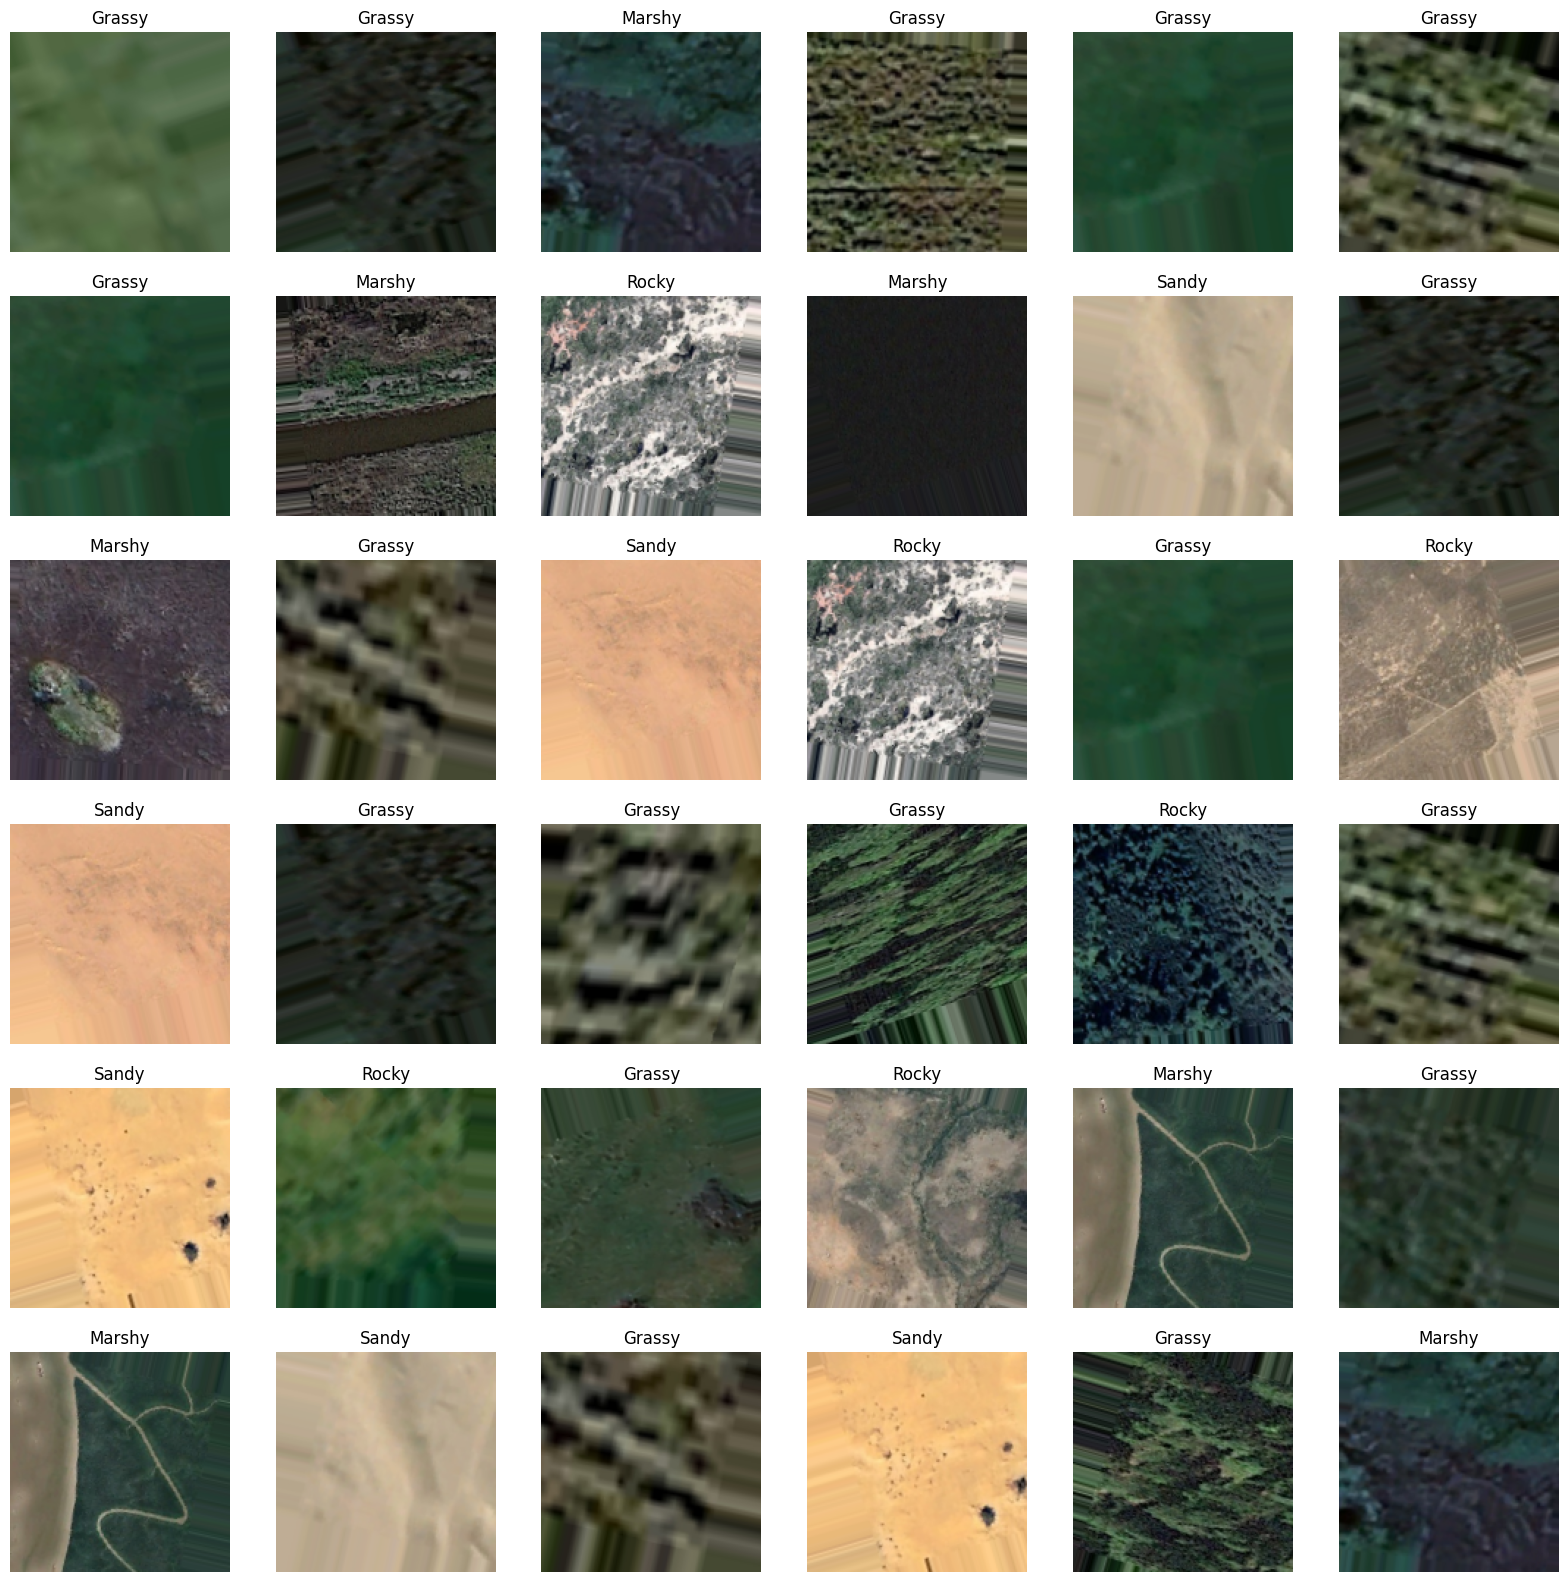

In [50]:
Show_Images(train_generator)

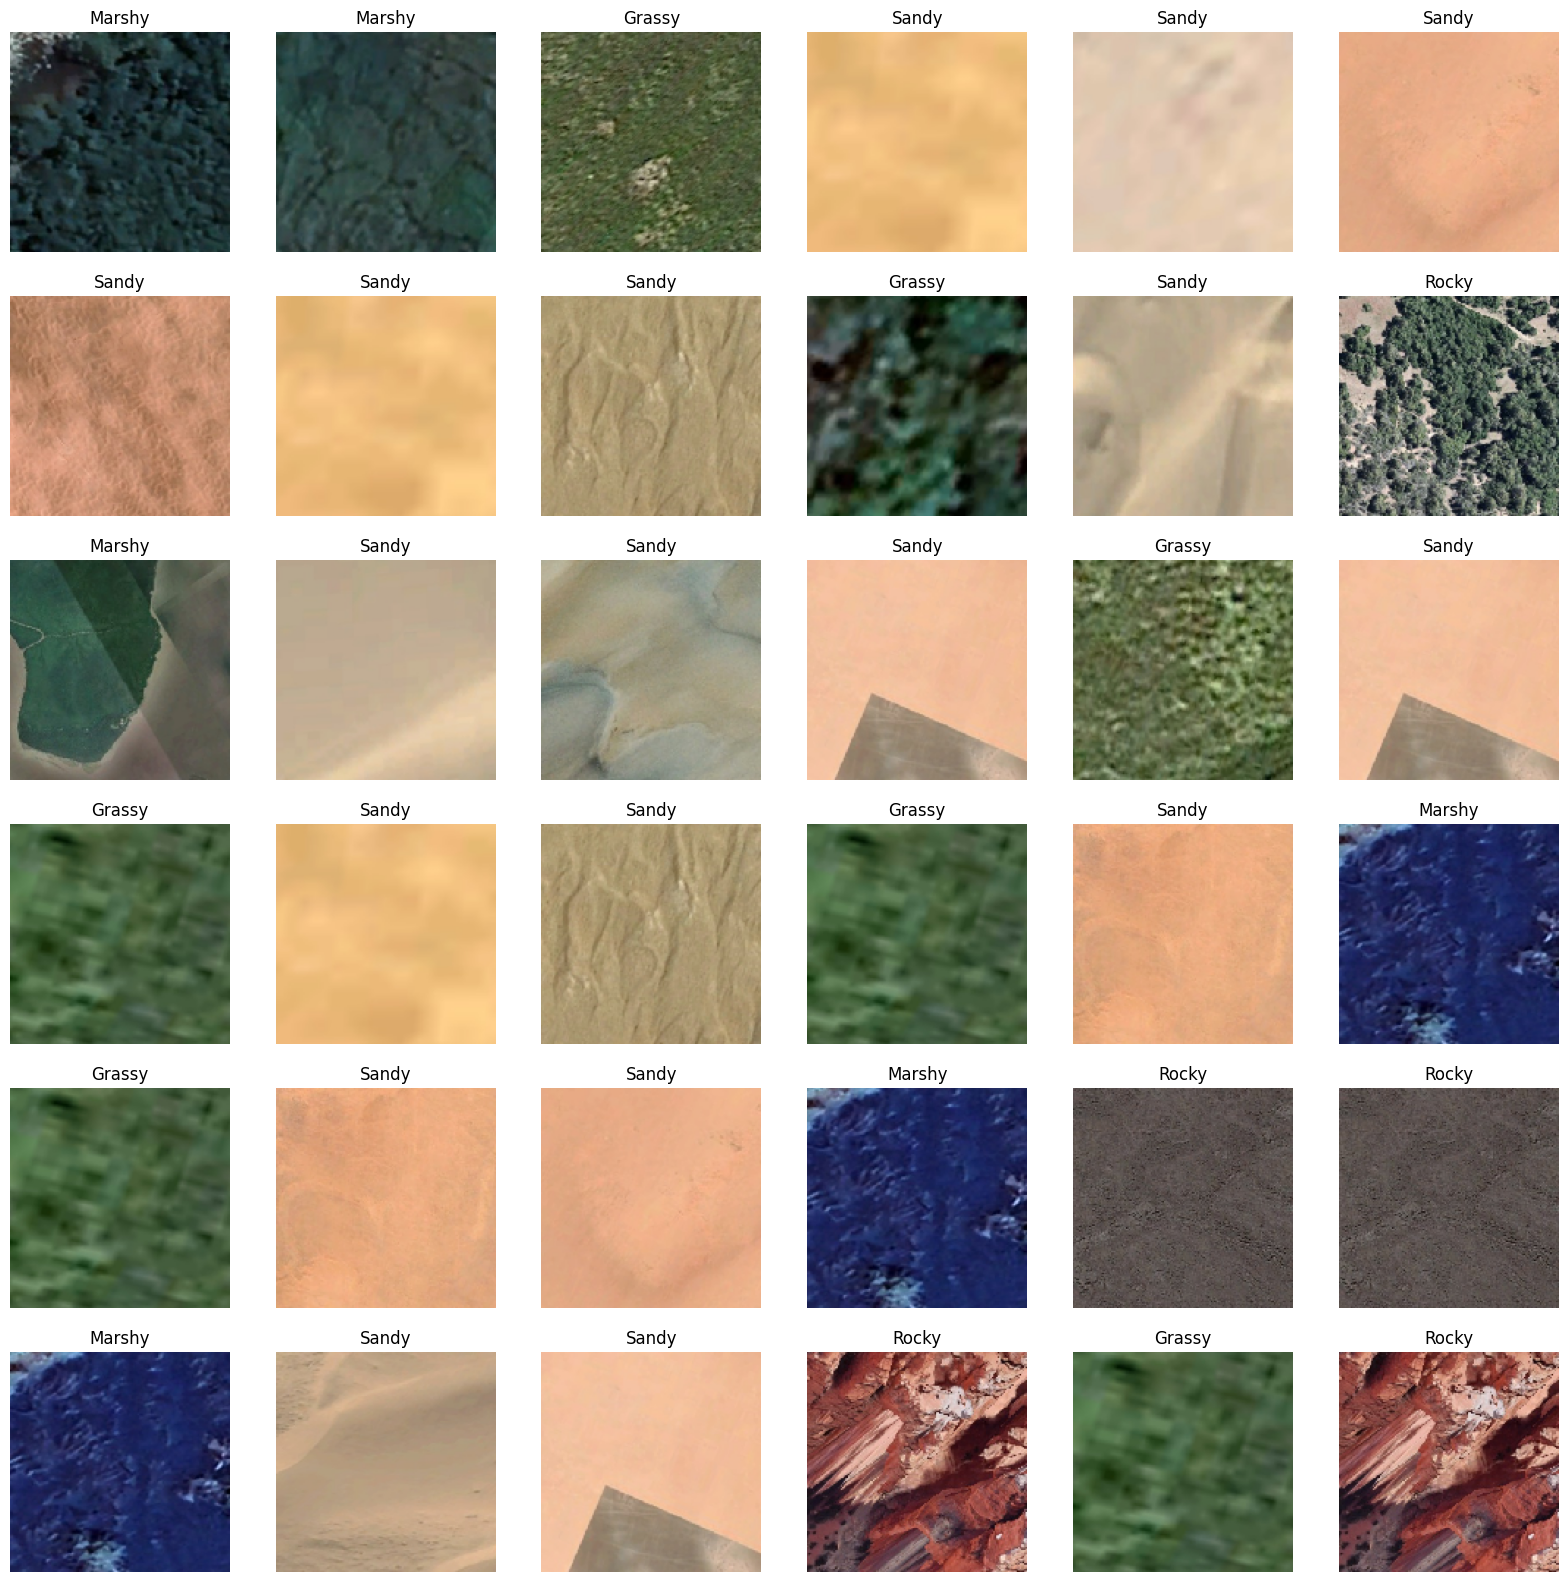

In [51]:
Show_Images(test_generator)

In [52]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [53]:
# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

In [54]:
from tensorflow.keras.applications import ResNet101
base_model=ResNet101(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))

In [55]:
# from tensorflow.keras.applications import NASNetLarge
# base_model=NASNetLarge(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))

In [56]:
# from tensorflow.keras.applications import InceptionV3
# base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))

In [57]:
# from tensorflow.keras.applications import DenseNet201
# base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))

In [58]:
# Freeze the layers of the base model

for layer in base_model.layers:
    layer.trainable = False

In [59]:
from tensorflow.keras import layers
model = tf.keras.models.Sequential([
    base_model,
    
    layers.Flatten(),
    
    layers.Dense(256,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6,activation='softmax'),
])

In [60]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 5, 5, 2048)        42658176  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               13107456  
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 6)                

In [61]:
# Define the parameters for the exponential decay schedule
initial_learning_rate = 0.1     # Initial learning rate
decay_steps = 1000              # Number of steps before decaying the learning rate
decay_rate = 0.5                # Rate at which the learning rate decays
staircase = True                # Whether to use staircase decay (integer division of step by decay_steps)

# Create the exponential decay schedule
def lr_schedule(epoch, lr):
    if staircase:
        return lr * decay_rate ** (epoch // decay_steps)
    else:
        return lr * decay_rate ** (epoch / decay_steps)

In [62]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [63]:
# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

In [64]:
from keras.callbacks import LearningRateScheduler

lr_callback = LearningRateScheduler(lr_schedule)
callback=[early_stopping , learning_rate_reduce , lr_callback]

In [65]:
model.compile(optimizer=keras.optimizers.Adam(lr=lr_callback),
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

In [66]:
from tensorflow.keras.layers import Dense

# Get the model architecture up to the last layer
model = tf.keras.Sequential(model.layers[:-1])

# Add a new output layer for 4 classes
new_output = Dense(4, activation='softmax')  # Assuming 4 classes
model.add(new_output)  # Add the new output layer

# Compile the model again after modifying the architecture
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [67]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[EarlyStopping(patience=3)]
)

Epoch 1/10
986/986 [==============================] - 330s 327ms/step - loss: 1.1291 - accuracy: 0.4746 - val_loss: 0.8316 - val_accuracy: 0.6484
Epoch 2/10
986/986 [==============================] - 317s 321ms/step - loss: 0.7941 - accuracy: 0.6551 - val_loss: 0.6162 - val_accuracy: 0.7473
Epoch 3/10
986/986 [==============================] - 315s 319ms/step - loss: 0.7095 - accuracy: 0.6949 - val_loss: 0.6433 - val_accuracy: 0.7188
Epoch 4/10
986/986 [==============================] - 317s 321ms/step - loss: 0.6793 - accuracy: 0.7103 - val_loss: 0.6322 - val_accuracy: 0.7229
Epoch 5/10
986/986 [==============================] - 322s 327ms/step - loss: 0.6420 - accuracy: 0.7341 - val_loss: 0.5678 - val_accuracy: 0.7694
Epoch 6/10
986/986 [==============================] - 319s 323ms/step - loss: 0.6256 - accuracy: 0.7445 - val_loss: 0.5436 - val_accuracy: 0.7778
Epoch 7/10
986/986 [==============================] - 319s 324ms/step - loss: 0.6025 - accuracy: 0.7552 - val_loss: 0.5273 -

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [68]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5019219517707825
Test accuracy: 0.789333701133728


<Figure size 640x480 with 0 Axes>

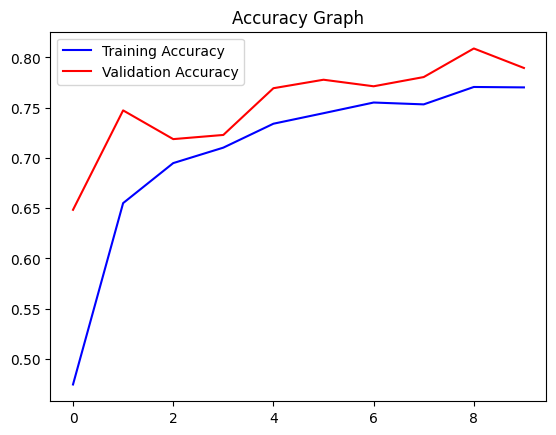

<Figure size 640x480 with 0 Axes>

In [69]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

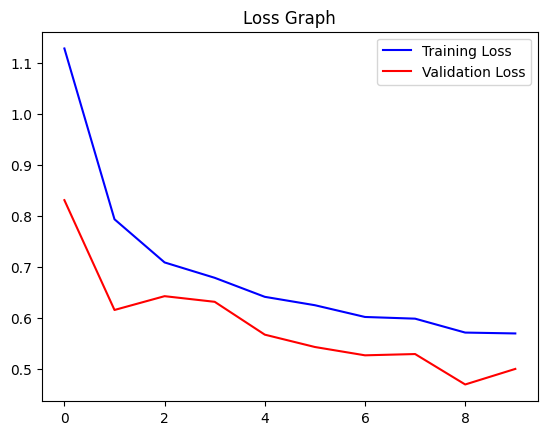

In [70]:
# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [71]:
# model.save("terrain-recog.h5")
class_names = [
    "Rocky",
    "Sandy",
    "Grassy",
    "Marshy"
]

In [72]:
confusion_matrix_input_generator = train_datagen.flow_from_directory(
    test_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size = 4000,        # Number of images in each batch
    class_mode ='categorical'       # Mode for class labels (categorical for one-hot encoding)
)


Found 6769 images belonging to 4 classes.


In [73]:
pred_test_batch, pred_test_batch_result = next(confusion_matrix_input_generator)
y_pred = model.predict(pred_test_batch)

125/125 [==============================] - 12s 84ms/step


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

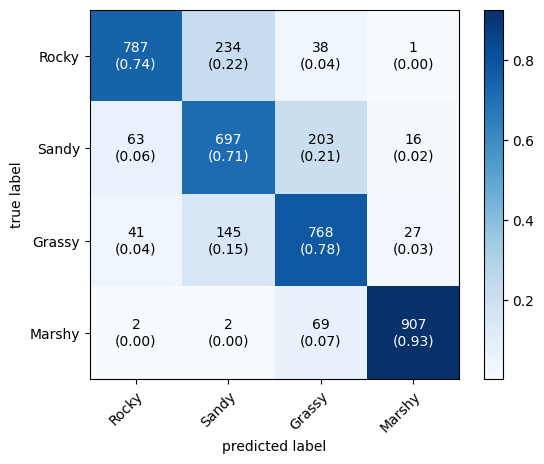

In [74]:
mat = confusion_matrix(np.argmax(pred_test_batch_result, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(conf_mat = mat,show_absolute=True,show_normed=True,colorbar=True,class_names=class_names)

In [75]:
from sklearn.metrics import f1_score

In [76]:
f1_macro = f1_score(np.argmax(pred_test_batch_result, axis=1), np.argmax(y_pred, axis=1), average='macro') 
f1_micro = f1_score(np.argmax(pred_test_batch_result, axis=1), np.argmax(y_pred, axis=1), average='micro') 

In [77]:
print("f1 macro score",f1_macro ,"\nf2 micro score" , f1_micro)

f1 macro score 0.7922570908610054 
f2 micro score 0.78975


In [78]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, _, __ = score(np.argmax(pred_test_batch_result, axis=1), np.argmax(y_pred, axis=1))
precision = np.round_(precision, decimals = 3) 
recall = np.round_(recall, decimals = 3) 
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

precision: [0.881 0.647 0.712 0.954]
recall: [0.742 0.712 0.783 0.926]


In [79]:
print("Precision and Recall of Each class")
print("ClassName | precision | recall")
print("----------+-----------+-------")
for i in range(4):
    print(class_names[i].ljust(len("ClassName")," "),"|", str(precision[i]).ljust(len("precision"), " "),"|", recall[i])

Precision and Recall of Each class
ClassName | precision | recall
----------+-----------+-------
Rocky     | 0.881     | 0.742
Sandy     | 0.647     | 0.712
Grassy    | 0.712     | 0.783
Marshy    | 0.954     | 0.926


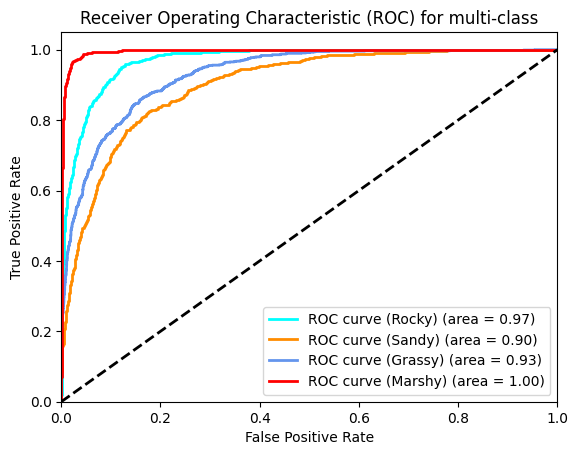

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

y_true = pred_test_batch_result
y_scores = y_pred

n_classes = 4
y_bin = label_binarize(y_true, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve ({0}) (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for multi-class')
plt.legend(loc="lower right")
plt.show()
